In [1]:
# List of Imports
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import geopandas as gpd
import pandana as pdna
from pandana.loaders import osm
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


from shapely.geometry import Point


In [2]:
# Load Network saved data
store = pd.HDFStore('./data/portugal', 'r')
nodes = store.nodes
edges = store.edges

This is a long routine to generate a new Node_DF in geodataframe, to create the Sjoin with the SubSection Polygons

In [3]:
def generate_points(row):
    point = Point(row.x, row.y)
    return point

nodes['geometry'] = nodes.apply(lambda row: generate_points(row), axis=1)

In [4]:
#  Old and very slow code...
# listOfPoints = []
# for e in nodes.iterrows():
#     point = Point(e[1].x, e[1].y)
#     listOfPoints.append(point)
# nodes['geometry'] = listOfPoints

In [5]:
joinDf = gpd.GeoDataFrame(nodes)

In [6]:
# Load data Polygons
polygons = gpd.read_file('./data/BGRI_2011/CONTINENTE/BGRI11_CONT.shp')

# Add a column with all centroids
polygons = polygons.to_crs({'init': 'epsg:4326'})
centroid = polygons.centroid
polygons['sCentroid'] = centroid

In [7]:
myDf = gpd.sjoin(joinDf, polygons[['BGRI11', 'geometry']], how='left', op='intersects')
# myDf = myDf.loc[myDf['LUG11DESIG']!='Residual']

In [8]:
# Load and preprocess the network
network = pdna.Network(myDf.x,
                       myDf.y,
                       edges['from'], 
                       edges['to'],
                       edges[['dist']])
network.precompute(30000)

In [9]:
# Load Schools Data
schoolsNetwork = gpd.read_file('./data/escolas_portugal/Escolas_EB1_2019_2.shp')

In [10]:
# convert coordinates data from schools
schoolsNetwork = schoolsNetwork.to_crs({'init': 'epsg:4326'})

In [11]:
# Break the X and Y from the schools Networks
schoolX = []
schoolY = []
for e in schoolsNetwork.iterrows():
    schoolX.append(e[1][20].x)
    schoolY.append(e[1][20].y)
schoolsNetwork['schoolX'] = schoolX
schoolsNetwork['schoolY'] = schoolY

In [12]:
# Set the pois with the X and Y
network.set_pois('school', 10000, 3, schoolsNetwork['schoolX'], schoolsNetwork['schoolY'])

In [13]:
a = network.nearest_pois(10000, "school", num_pois=3)

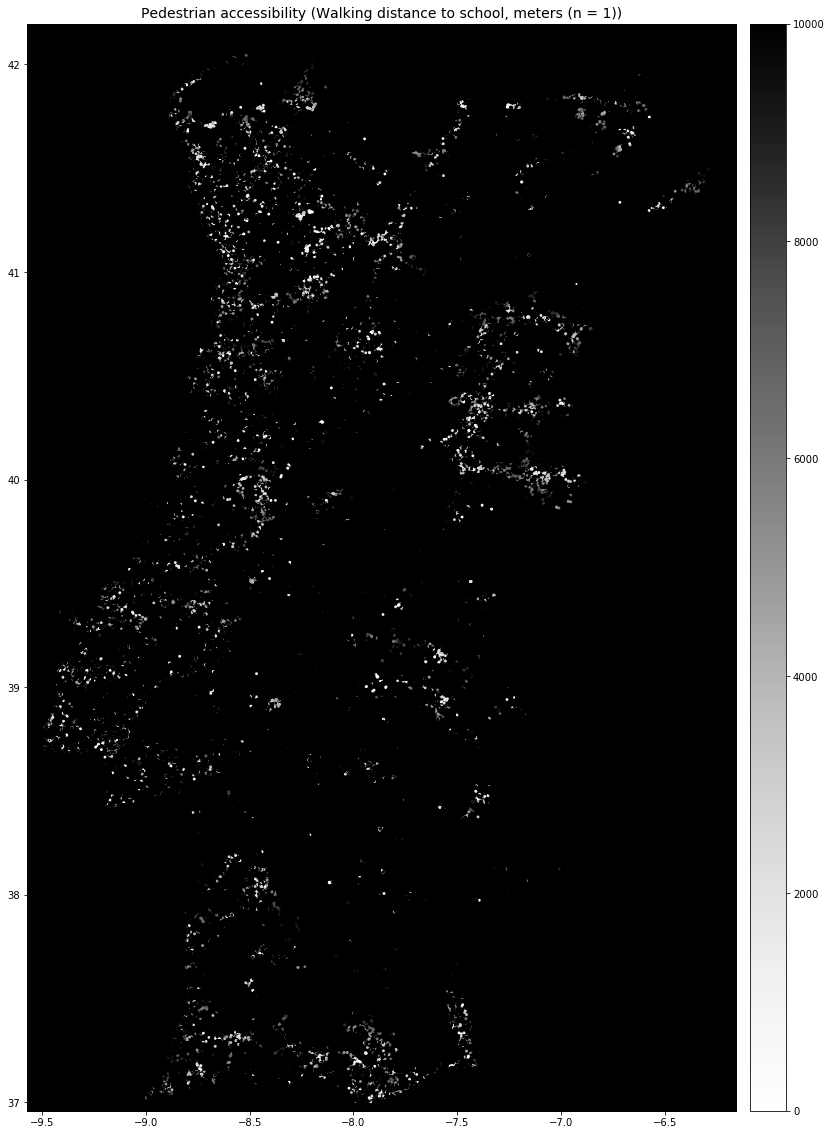

In [14]:
bbox = [-9.5725,36.9595,-6.1557,42.1967]
bbox = [bbox[1], bbox[0], bbox[3], bbox[2]]
def plot_nearest_amenity(amenity,accessibility, n):
    fig_kwargs = {'figsize': [20, 20]}
    bmap_kwargs = {'suppress_ticks': False, 'resolution': 'h', 'epsg': '4326'}
    plot_kwargs = {'cmap': 'Greys', 's': 8, 'edgecolor': 'none'}
    bmap,fig, ax = network.plot(accessibility[n], bbox=bbox,
                               fig_kwargs=fig_kwargs, bmap_kwargs=bmap_kwargs, plot_kwargs=plot_kwargs)
    ax.set_facecolor('k')
    ax.set_title('Pedestrian accessibility (Walking distance to {}, meters (n = {}))'.format(amenity,n), fontsize=14);

plot_nearest_amenity('school',a,1)

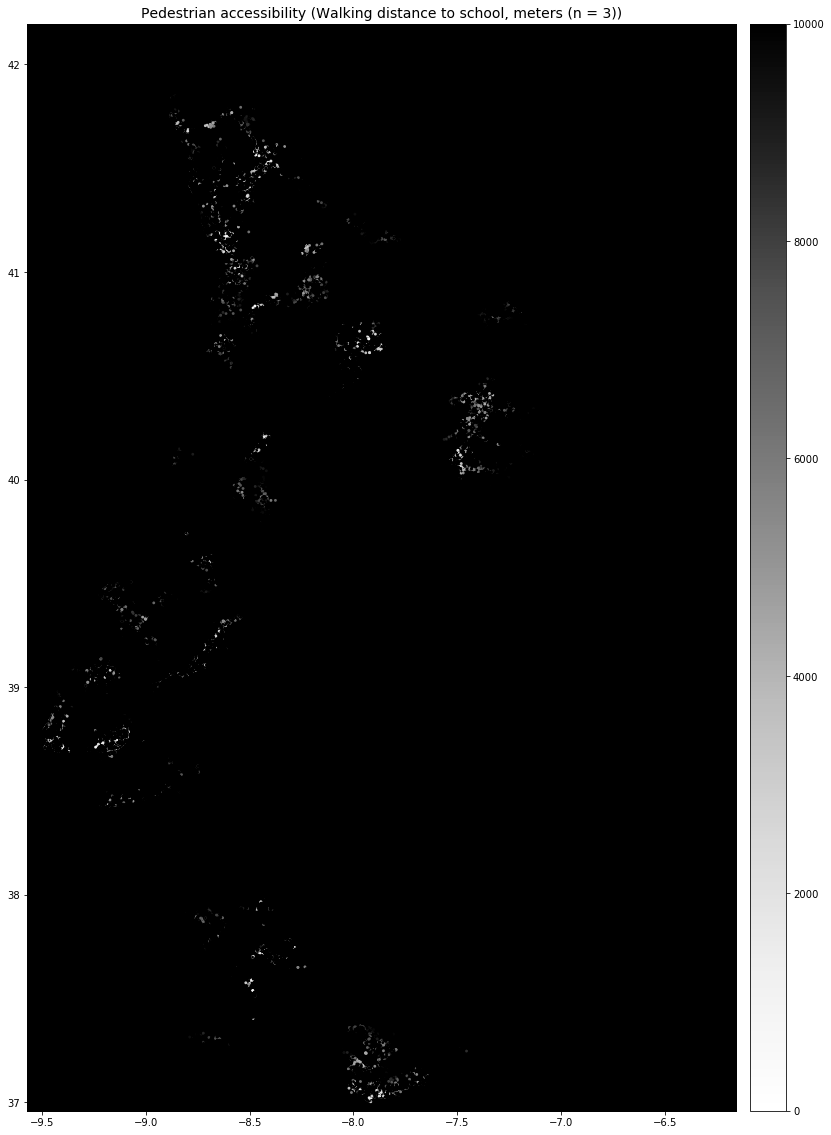

In [15]:
plot_nearest_amenity('school',a,3)

In [123]:
polygons.head()

,OBJECTID,DTMN11,FR11,SEC11,SS11,BGRI11,LUG11,LUG11DESIG,area,geometry,sCentroid
0,548,0407,02,001,04,04070200104,013810,Abreiro,0.114464,POLYGON ((-7.292053770028865 41.35148203894774...,POINT (-7.293648810336942 41.35251148035432)
1,549,0407,02,001,06,04070200106,013810,Abreiro,0.054224,"POLYGON ((-7.29253459906294 41.35105713908859,...",POINT (-7.293215396223582 41.3504459628436)
2,550,0407,02,001,01,04070200101,013811,Milhais,0.066225,POLYGON ((-7.327012455923839 41.35968788269845...,POINT (-7.328519819070368 41.35908435330851)
3,551,0407,02,001,02,04070200102,013811,Milhais,0.130057,POLYGON ((-7.321866619087325 41.36046656671141...,POINT (-7.325406442440722 41.35909614596699)
4,552,0407,29,001,03,04072900103,013866,Pai Torto,0.067553,POLYGON ((-7.274476644372521 41.51600100555503...,POINT (-7.275915390600979 41.5154669187225)


In [124]:
listToTest = myDf.loc[myDf['BGRI11']=='04070200104'].index
listToTest

Int64Index([724333, 730345], dtype='int64')

In [111]:
meanCalculation = a.iloc[listToTest.tolist(), :]

In [112]:
meanCalculation[1].mean()

10000.0

In [113]:
polygons_sample = polygons[:10]

In [ ]:
def generate_means(row, nodesDf, accessDf, nearestN=1):
    listToTest = nodesDf.loc[nodesDf['BGRI11']==row.BGRI11].index
    nodesInBGRI = accessDf.iloc[listToTest.tolist(), :]
    return nodesInBGRI[nearestN].mean()

polygons['accessMean'] = polygons.apply(lambda row: generate_means(row, myDf, a), axis=1)
polygons['accessMean_n3'] = polygons.apply(lambda row: generate_means(row, myDf, a, nearestN=3), axis=1)

In [ ]:
polygons.head()